<a href="https://colab.research.google.com/github/acarolr9/TechnicalCase/blob/main/PruebaTecnicaCarolinaLopezP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrevista Data Science
### Lectura de librerias

In [1]:
! pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.9 MB/s eta 0:00:00


In [2]:
import os

from google.colab import drive

if not os.path.isdir('/content/drive/My Drive'):
    # Montar Google Drive
    drive.mount('/content/drive')
else:
    print("Google Drive ya está montado.")

Mounted at /content/drive


In [3]:
import pandas as pd
import re
import time
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, Word2Vec, VectorAssembler
from pyspark.ml.functions import vector_to_array
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import sys
from pyspark.sql.types import StringType, DoubleType
from unidecode import unidecode

from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf, col
import numpy as np

### Lecturas Funciones propias

In [4]:
main_path = '/content/drive/My Drive/PruebaTecnica3/'
if main_path not in sys.path:
    sys.path.append(main_path)


#                     1. Similitud entre productos
---



In [5]:
spark = SparkSession.builder.appName("Similitud de Productos").getOrCreate()

# Leer los datos
items_titles = spark.read.csv(main_path+"items_titles.csv", header=True).withColumnRenamed("ITE_ITEM_TITLE", "title")
items_titles_test = spark.read.csv(main_path+"items_titles_test.csv", header=True).withColumnRenamed("ITE_ITEM_TITLE", "title")

In [6]:
items_titles.show(3)

+--------------------+
|               title|
+--------------------+
|Tênis Ascension P...|
|Tenis Para Caminh...|
|Tênis Feminino Le...|
+--------------------+
only showing top 3 rows



### Se realiza una limpieza general del texto

In [7]:
def limpiar_texto(texto):
    """
    Limpia el texto eliminando tildes, signos y normalizando espacios.
    """
    texto = unidecode(texto)  # Quitar tildes
    texto = re.sub(r'[^\w\s]', '', texto)  # Eliminar signos de puntuación
    texto = texto.lower()  # Convertir a minúsculas
    texto = re.sub(r'\s+', ' ', texto).strip()  # Normalizar espacios
    return texto

# Registrar la UDF en PySpark
limpiar_texto_udf = udf(limpiar_texto, StringType())

# Aplicar la UDF a las columnas
items_titles = items_titles.withColumn("title_clean", limpiar_texto_udf(col("title")))
items_titles_test = items_titles_test.withColumn("title_clean", limpiar_texto_udf(col("title")))

# Mostrar los resultados limpios
items_titles.show(5, truncate=False)
items_titles_test.show(5, truncate=False)

+-----------------------------------------------------------+-----------------------------------------------------------+
|title                                                      |title_clean                                                |
+-----------------------------------------------------------+-----------------------------------------------------------+
|Tênis Ascension Posh Masculino - Preto E Vermelho          |tenis ascension posh masculino preto e vermelho            |
|Tenis Para Caminhada Super Levinho Spider Corrida          |tenis para caminhada super levinho spider corrida          |
|Tênis Feminino Le Parc Hocks Black/ice Original Envio Já   |tenis feminino le parc hocks blackice original envio ja    |
|Tênis Olympikus Esportivo Academia Nova Tendência Triunfo  |tenis olympikus esportivo academia nova tendencia triunfo  |
|Inteligente Led Bicicleta Tauda Luz Usb Bicicleta Carregáve|inteligente led bicicleta tauda luz usb bicicleta carregave|
+-----------------------

### Se realiza el Embeddings de las oraciones con tfidf y word2vec

In [8]:

def fit_tfidf(df):
    """
    Ajusta el modelo TF-IDF en un DataFrame PySpark y genera los embeddings.

    Args:
        df (DataFrame): DataFrame PySpark con los datos de entrenamiento.

    Returns:
        DataFrame: DataFrame con la columna de embeddings TF-IDF agregada.
        IDFModel: Modelo TF-IDF ajustado.
    """
    KEEP_COLS = ['title', 'title_clean']  # Mantener solo columnas relevantes
    df = df.select(*KEEP_COLS)

    # Tokenización: Divide los textos en palabras
    tokenizer = Tokenizer(inputCol="title_clean", outputCol="words")
    words_data = tokenizer.transform(df)

    # Calcular las frecuencias brutas (TF)
    hashing_tf = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=500)
    featurized_data = hashing_tf.transform(words_data)

    # Ajustar el modelo IDF
    idf = IDF(inputCol="raw_features", outputCol="tfidf_features")
    idf_model = idf.fit(featurized_data)
    rescaled_data = idf_model.transform(featurized_data)

    # Ensamblar los datos en un solo vector para futuras operaciones
    assembler_tfidf = VectorAssembler(inputCols=["tfidf_features"], outputCol="features_tfidf")
    df_tfidf = assembler_tfidf.transform(rescaled_data)

    # Retornar DataFrame y modelo ajustado

    return df_tfidf.select(*KEEP_COLS + ['features_tfidf']), idf_model

In [9]:
def apply_tfidf(df, model):
    """
    Aplica un modelo TF-IDF previamente ajustado a un nuevo DataFrame PySpark.

    Args:
        df (DataFrame): DataFrame PySpark con los datos de prueba.
        model (IDFModel): Modelo TF-IDF previamente ajustado.

    Returns:
        DataFrame: DataFrame con la columna de embeddings TF-IDF agregada.
    """
    KEEP_COLS = ['title', 'title_clean']  # Mantener solo columnas relevantes
    df = df.select(*KEEP_COLS)

    # Tokenización: Divide los textos en palabras
    tokenizer = Tokenizer(inputCol="title_clean", outputCol="words")
    words_data = tokenizer.transform(df)

    # Calcular las frecuencias brutas (TF)
    hashing_tf = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=500)
    featurized_data = hashing_tf.transform(words_data)

    # Aplicar el modelo IDF para escalar las frecuencias
    rescaled_data = model.transform(featurized_data)

    # Ensamblar los datos en un solo vector para futuras operaciones
    assembler_tfidf = VectorAssembler(inputCols=["tfidf_features"], outputCol="features_tfidf")
    df_tfidf = assembler_tfidf.transform(rescaled_data)

    # Retornar DataFrame transformado
    return df_tfidf.select(*KEEP_COLS + ['features_tfidf'])

In [10]:
start_tfidf = time.time()
train_tfidf, tfidf_model = fit_tfidf(items_titles)
test_tfidf = apply_tfidf(items_titles_test, tfidf_model)
end_tfidf = time.time()
tfidf_time = end_tfidf - start_tfidf
train_tfidf.show(5, truncate=False)
test_tfidf.show(5, truncate=False)

+-----------------------------------------------------------+-----------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|title                                                      |title_clean                                                |features_tfidf                                                                                                                                                                                                |
+-----------------------------------------------------------+-----------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Tênis Ascens

In [11]:

def fit_word2vec(df):
    """
    Ajusta el modelo Word2Vec en un DataFrame PySpark y genera los embeddings.

    Args:
        df (DataFrame): DataFrame PySpark con los datos de entrenamiento.

    Returns:
        DataFrame: DataFrame con la columna de embeddings Word2Vec agregada.
        Word2VecModel: Modelo Word2Vec ajustado.
    """
    KEEP_COLS = ['title', 'title_clean']  # Mantener solo columnas relevantes
    df = df.select(*KEEP_COLS)

    # Tokenización: Divide los textos en palabras
    tokenizer = Tokenizer(inputCol="title_clean", outputCol="words")
    words_data = tokenizer.transform(df)

    # Ajustar Word2Vec
    word2vec = Word2Vec(inputCol="words", outputCol="word2vec_features", vectorSize=500)
    word2vec_model = word2vec.fit(words_data)
    word2vec_data = word2vec_model.transform(words_data)

    # Ensamblar los datos en un solo vector
    assembler_word2vec = VectorAssembler(inputCols=["word2vec_features"], outputCol="features_word2vec")
    df_word2vec = assembler_word2vec.transform(word2vec_data)

    # Retornar DataFrame y modelo ajustado
    return df_word2vec.select(*KEEP_COLS + ['features_word2vec']), word2vec_model

In [12]:
def apply_word2vec(df, model):
    """
    Aplica un modelo Word2Vec previamente ajustado a un nuevo DataFrame PySpark.

    Args:
        df (DataFrame): DataFrame PySpark con los datos de prueba.
        model (Word2VecModel): Modelo Word2Vec previamente ajustado.

    Returns:
        DataFrame: DataFrame con la columna de embeddings Word2Vec agregada.
    """
    KEEP_COLS = ['title', 'title_clean']  # Mantener solo columnas relevantes
    df = df.select(*KEEP_COLS)

    # Tokenización: Divide los textos en palabras
    tokenizer = Tokenizer(inputCol="title_clean", outputCol="words")
    words_data = tokenizer.transform(df)

    # Aplicar Word2Vec
    word2vec_data = model.transform(words_data)

    # Ensamblar los datos en un solo vector
    assembler_word2vec = VectorAssembler(inputCols=["word2vec_features"], outputCol="features_word2vec")
    df_word2vec = assembler_word2vec.transform(word2vec_data)

    # Retornar DataFrame transformado
    return df_word2vec.select(*KEEP_COLS + ['features_word2vec'])

In [13]:
start_w2vec = time.time()
train_w2vec, word2vec_model = fit_word2vec(items_titles)
test_w2vec = apply_word2vec(items_titles_test,word2vec_model)
end_w2vec = time.time()
w2vec_time = end_w2vec - start_w2vec
train_w2vec.show(5, truncate=False)
test_w2vec.show(5, truncate=False)

+-----------------------------------------------------------+-----------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Se une la base principal con test

In [14]:

def renombrar_columnas(df, sufijo="_test"):
    return df.select([col(c).alias(f"{c}{sufijo}") for c in df.columns])

test_tfidf = renombrar_columnas(test_tfidf, sufijo="_test")
test_w2vec = renombrar_columnas(test_w2vec, sufijo="_test")
from pyspark.sql.functions import monotonically_increasing_id

# Agregar un ID único a cada fila en los DataFrames
train_tfidf = train_tfidf.withColumn("id", monotonically_increasing_id())
test_tfidf = test_tfidf.withColumn("id_test", monotonically_increasing_id())

train_w2vec = train_w2vec.withColumn("id", monotonically_increasing_id())
test_w2vec = test_w2vec.withColumn("id_test", monotonically_increasing_id())

# Definir una función para calcular la similitud del coseno
def cosine_similarity(vec1, vec2):
    """
    Calcula la similitud del coseno entre dos vectores.
    """
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0.0 or norm2 == 0.0:
        return 0.0
    return float(dot_product / (norm1 * norm2))

# Registrar la función como UDF
cosine_similarity_udf = udf(cosine_similarity, DoubleType())

# **2. Cruce de Datos para Calcular Similitudes**
def calcular_similitudes_spark(df1, df2, feature_col, output_col):
    """
    Calcula las similitudes del coseno entre embeddings de dos DataFrames de Spark.

    Args:
        df1: DataFrame de referencia.
        df2: DataFrame de prueba.
        feature_col: Columna de embeddings para comparar.
        output_col: Nombre de la columna de salida con la similitud.

    Returns:
        DataFrame: Resultados con similitudes calculadas.
    """
    # Asignar alias a los DataFrames
    df1 = df1.alias("df1")
    df2 = df2.alias("df2")

    # Cruce cartesiano entre los DataFrames
    cruzado = df1.crossJoin(df2)

    # Calcular similitud del coseno usando las columnas con alias
    return cruzado.withColumn(
        output_col,
        cosine_similarity_udf(
            col(f"df1.{feature_col}"),
            col(f"df2.{feature_col}_test")
        )
    )
# Aplicar a TF-IDF
start_sim_tfidf = time.time()
similitudes_tfidf_df = calcular_similitudes_spark(train_tfidf, test_tfidf, "features_tfidf", "similarity_tfidf")
end_sim_tfidf = time.time()
sim_tfidf_time = end_sim_tfidf - start_sim_tfidf

# Aplicar a Word2Vec
start_sim_w2vec = time.time()
similitudes_w2vec_df = calcular_similitudes_spark(train_w2vec, test_w2vec, "features_word2vec", "similarity_word2vec")
end_sim_w2vec = time.time()
sim_w2vec_time = end_sim_w2vec - start_sim_w2vec

In [15]:
similitudes_tfidf_df.show(4)

+--------------------+--------------------+--------------------+---+--------------------+--------------------+--------------------+-------+--------------------+
|               title|         title_clean|      features_tfidf| id|          title_test|    title_clean_test| features_tfidf_test|id_test|    similarity_tfidf|
+--------------------+--------------------+--------------------+---+--------------------+--------------------+--------------------+-------+--------------------+
|Tênis Ascension P...|tenis ascension p...|(500,[37,50,100,1...|  0|Tênis Olympikus E...|tenis olympikus e...|(500,[76,145,226,...|      0| 0.04037879196744135|
|Tênis Ascension P...|tenis ascension p...|(500,[37,50,100,1...|  0|Bicicleta Barra F...|bicicleta barra f...|(500,[65,75,111,1...|      1|                 0.0|
|Tênis Ascension P...|tenis ascension p...|(500,[37,50,100,1...|  0|Tênis Usthemp Sli...|tenis usthemp sli...|(500,[308,386,392...|      2|0.001225457135613...|
|Tênis Ascension P...|tenis ascens

In [16]:
similitudes_w2vec_df.show(4)

+--------------------+--------------------+--------------------+---+--------------------+--------------------+----------------------+-------+--------------------+
|               title|         title_clean|   features_word2vec| id|          title_test|    title_clean_test|features_word2vec_test|id_test| similarity_word2vec|
+--------------------+--------------------+--------------------+---+--------------------+--------------------+----------------------+-------+--------------------+
|Tênis Ascension P...|tenis ascension p...|[0.03882070690659...|  0|Tênis Olympikus E...|tenis olympikus e...|  [0.01274268236011...|      0|  0.8154881058465105|
|Tênis Ascension P...|tenis ascension p...|[0.03882070690659...|  0|Bicicleta Barra F...|bicicleta barra f...|  [0.00631863273447...|      1|-0.13028133939726835|
|Tênis Ascension P...|tenis ascension p...|[0.03882070690659...|  0|Tênis Usthemp Sli...|tenis usthemp sli...|  [0.01877336033309...|      2| 0.14090701946518536|
|Tênis Ascension P...|

In [ ]:
# Realizar el join por id y id_test
resultados_combinados_df = similitudes_tfidf_df.alias("tfidf").join(
    similitudes_w2vec_df.alias("w2vec"),
    on=["id", "id_test"],
    how="inner"
).select(
    col("tfidf.title").alias("title"),
    col("tfidf.title_clean").alias("title_clean"),
    col("tfidf.similarity_tfidf").alias("similarity_tfidf"),
    col("w2vec.similarity_word2vec").alias("similarity_word2vec")
)

# Mostrar los resultados combinados
resultados_combinados_df.limit(4).show(4)


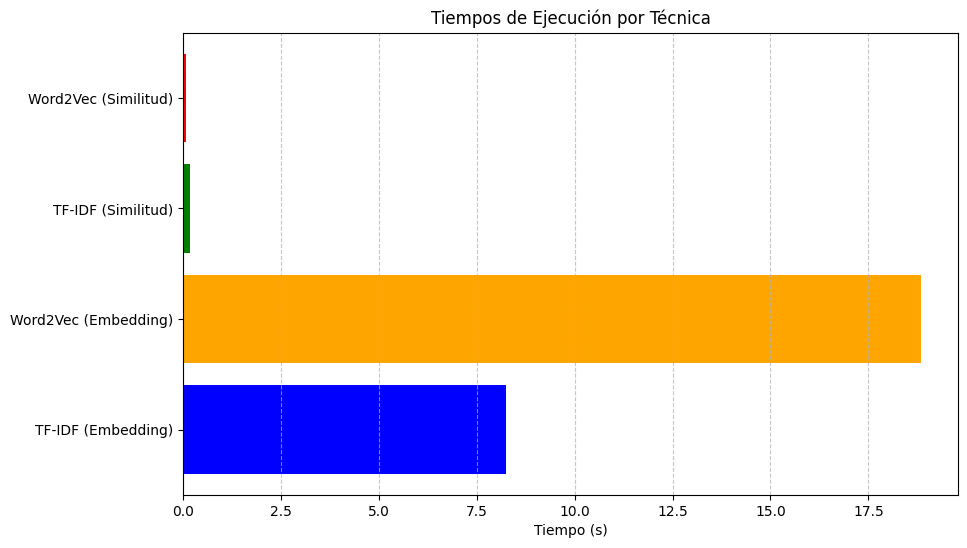


Tiempos de Ejecución:
                Técnica  Tiempo (s)
0    TF-IDF (Embedding)    8.240720
1  Word2Vec (Embedding)   18.845807
2    TF-IDF (Similitud)    0.168589
3  Word2Vec (Similitud)    0.070945


In [18]:

tiempos_df = pd.DataFrame({
    "Técnica": ["TF-IDF (Embedding)", "Word2Vec (Embedding)", "TF-IDF (Similitud)", "Word2Vec (Similitud)"],
    "Tiempo (s)": [tfidf_time, w2vec_time, sim_tfidf_time, sim_w2vec_time]
})

# Graficar tiempos
plt.figure(figsize=(10, 6))
plt.barh(tiempos_df["Técnica"], tiempos_df["Tiempo (s)"], color=["blue", "orange", "green", "red"])
plt.xlabel("Tiempo (s)")
plt.title("Tiempos de Ejecución por Técnica")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

# Mostrar los tiempos
print("\nTiempos de Ejecución:")
print(tiempos_df)